## $Mixture$ $Probability$ $Distributions$

Estimation of distribution algorithms have been shown to perform well on a wide variety of single–objective optimization problems. Here, we look at a simple - yet effective - extension of this paradigm for multi–objective optimization, called the naive MIDEA. The probabilistic model in this specific algorithm is a mixture distribution, and each component in the mixture is a univariate factorization. Mixture distributions allow for wide–spread exploration of the Pareto front thus aiding the important preservation of diversity in multi–objective optimization. Due to its simplicity, speed, and effectiveness the naive MIDEA can well serve as a baseline algorithm for multi–objective evolutionary algorithms.

<img src='http://upload.wikimedia.org/wikipedia/commons/1/1b/Bivariate_example.png' align='center'/>

## $Multiobjective$ $optimization$ $(Pareto$ $optimal$ $front)$

In multi-objective optimization we want the solutions to be as close to the Pareto optimal front as possible, and we want a good diverse representation of the Pareto optimal front. In a practical application, we have no indication of how close we are to the Pareto optimal front. To ensure selection pressure toward the Pareto optimal front in the absence of such information, the best we can do is to find solutions that are dominated as little as possible by any other solution. A straightforward way to obtain selection pressure toward non–dominated solutions is therefore to count for each solution in the population the number of times it is dominated by another solution in the population, which is called the domination count of a solution

<img src='http://www.scielo.br/img/revistas/pope/2012nahead/2612fig02.jpg' align='center'/>

## $Load$ $Libraries$

In [1]:
## import graphics libraries
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import figure
from matplotlib import animation
from IPython.display import Image

## import standard libraries
import array
import bisect
import copy
import json
import math
import numpy as np
import operator
import random
from collections import defaultdict
from itertools import repeat
from math import sqrt

## import naive MIDEA libraries
import problems
from deap import base, creator, tools
from deap.benchmarks.tools import diversity, convergence 
from hv import HyperVolume
from scipy.cluster.vq import kmeans,vq
from scipy.stats import norm

## define graphics style
font = {'size': 9}
matplotlib.rc('font', **font)

## $Benchmark$ $Problem$ $Defining$

In [2]:
# Load Benchmark Problem
problem = problems.WFG1

# Functions zdt1, zdt2, zdt3 have 30 dimensions, zdt4 and zdt6 have 10, WFG1 have 6 dimensions
NDIM = 6

# Functions zdt1, zdt2, zdt3, zdt6 have bounds [0, 1]
BOUND_LOW, BOUND_UP = 0.0, 1.0

## $Evolution$ $parameters$ $defining$ $(individuals$ $and$ $operators)$

In [3]:
def uniform(low, up, size=None):
    try:
        return [random.uniform(a, b) for a, b in zip(low, up)]
    except TypeError:
        return [random.uniform(a, b) for a, b in zip([low] * size, [up] * size)]
    
creator.create("FitnessMin", base.Fitness, weights=(-1.0, -1.0))
creator.create("Individual", array.array, typecode='d', fitness=creator.FitnessMin)
toolbox = base.Toolbox()
toolbox.register("attr_float", uniform, BOUND_LOW, BOUND_UP, NDIM)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.attr_float)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", problem, k=2, l=4, M=2) # k=2, l=4, M=2 for WFG1
#toolbox.register("evaluate", problem)
toolbox.register("select", tools.selNSGA2)

## $Selection$ $Operator$ $naive$ $MIDEA$

In [4]:
######################################
# Selection Operator (naiveMIDEA)   #
######################################

def selnaiveMIDEA(self,tau):
    """Apply naiveMIDEA selection operator on the "individuals", the size
    of return population will be larger than "N*tau", where "tau" is a selection
    theresold parameter. A straightforward way to obtain selection pressure 
    toward non– dominated solutions is therefore to count for each solution in
    the population the number of times it is dominated by another solution in the
    population, which is called the domination count of a solution.
    The "N*tau" list returned contains references to the input "individuals". 
    For more details on the naiveMIDEA selection operator see [Bozman and Thierens 2006]_.
    
    :param self: A list of individuals to select from "N".
    :param tau: threshold param for select population [0,1]  
    :returns: A list of (tau*N) selected individuals.
    
    .. [Bosman and D. Thierens] Bosman and Thierens, "Multi-objective 
       Optimization with the NaiveMIDEA",
       StudFuzz 192, 123-157 (2006). Springer-Verlag Berlin Heidelberg 2006.
    """
    
    if len(self) == 0:
       return []

    def getKey(_item):
        return _item[1]
    
    def Range_Samples(_Sp):
        aux = [(ind.values) for ind in _Sp]
        aux_Sp = np.asarray(aux)
        f1_min = min(aux_Sp[::,0])
        f1_max = max(aux_Sp[::,0])
        f2_min = min(aux_Sp[::,1])
        f2_max = max(aux_Sp[::,1])
        md_f1 = (f1_max-f1_min)**2
        md_f2 = (f2_max-f2_min)**2
        return md_f1, md_f2

    def scaledEuclideanDist(Sample1,Sample2,md_f1,md_f2):
        value = (np.asarray(Sample1.values) - np.asarray(Sample2.values))**2
        result = value[0]/md_f1 + value[1]/md_f2
        return sqrt(result)
    
    def compNN_Dist(_Sp,_threshold):
        md_f1,md_f2 = Range_Samples(_Sp)
        S = list()
        S.append(sorted(_Sp, reverse=True)[0])
        del _Sp[0]  
        while (len(S) <= _threshold):
            NN_Dist = list()
            for i in range(len(_Sp)):
                dist = scaledEuclideanDist(S[-1],_Sp[i],md_f1,md_f2)
                NN_Dist.append(dist)
            ind_max = NN_Dist.index(max(NN_Dist)) 
            S.append(_Sp[ind_max])
            del _Sp[ind_max]
        return S

    #Assign variables and constants
    N = len(self)
    threshold = int(np.floor(N*tau))
    non_dom_count = 0
    dominating_fits = defaultdict(int)
    
    #Save index population 
    map_fit_ind = defaultdict(list)
    for ind in self:
        map_fit_ind[ind.fitness].append(ind)
    fits = map_fit_ind.keys()
    
    #Assign Domination Count for each individual 
    for i, fit_i in enumerate(fits):
        #for fit_j in fits[i+1:]:
        for fit_j in fits:
            if fit_i.dominates(fit_j):
                dominating_fits[fit_j] += 1
            elif fit_j.dominates(fit_i):
                dominating_fits[fit_i] += 1
        if dominating_fits[fit_i] == 0:
            non_dom_count +=1
     
    #Ordering individuals according to Domination Count Parameter 
    order_count = list()
    for k in dominating_fits.keys():
        value = dominating_fits[k]
        order_count.append([k,value])
    
    order_count = sorted(order_count, key=getKey) 
    order_fits = list()
    for i in range(len(order_count)):
        order_fits.append(order_count[i][0])
        
    #MIDEA selection: case1 (#ND_Count <= tao*N), case2(#ND_Count > tao*N)
    if non_dom_count <= threshold:
        return map_fit_ind, order_fits[:threshold], threshold #return chosen
    else:
        indi = 0
        
        while (order_count[indi][1] == 0):
            indi += 1
            if indi == len(order_count):
                break
        Sp = order_fits[:indi]     
        S = compNN_Dist(Sp,threshold)
        return map_fit_ind, S, threshold 

## $MPD$ $Estimation$ $naive$ $MIDEA$

In [5]:
#######################################################
# Estimate a MPD from select solutions (naive MIDEA)  #
#######################################################

def estMPDnMIDEA(self,tau,k):
    """Implementation of the naive MIDEA with normal pdfs,univariate
    factorizations and clustering (using the k-Means algorithm).
    The generation of new solutions is done by sampling the univariate
    factorization after selecting a cluster to sample from. 
    For more details on the naive MIDEA selection operator see [Bozman and Thierens 2006]_.
    
    :param pop: A list of individuals to select from "N".
    :param tau: threshold param for select population [0,1]   
    :param k: number of clusters 
    :returns: A list of N individuals (tau*N + (N-tau*N)) selected individuals.
    
    .. [Bosman and D. Thierens] Bosman and Thierens, "Multi-objective 
       Optimization with the naive MIDEA",
       StudFuzz 192, 123-157 (2006). Springer-Verlag Berlin Heidelberg 2006.
    """
    size_pop = len(self) 
    if (size_pop == 0) or ((size_pop*tau) < k):
       return []
    
    #Normalization is done with respect to the range of the
    #samples in the solution vector in each dimension.
    def scaling(vec):
        scaled_vec = copy.deepcopy(vec)
        f1_min = min(scaled_vec[::,0])
        f1_max = max(scaled_vec[::,0])
        f2_min = min(scaled_vec[::,1])
        f2_max = max(scaled_vec[::,1])
        for i in range(len(scaled_vec)):
            scaled_vec[i][0] = vec[i][0]/(f1_max - f1_min)
            scaled_vec[i][1] = vec[i][1]/(f2_max - f2_min)
        return scaled_vec
    
    #Select a factorization based on the mixing coefficients
    def choose_indx(mix_coef):
        r = random.random()
        index = 0
        while(r >= 0 and index < len(mix_coef)):
            r -= mix_coef[index]
            index += 1
        return index - 1

    #Estimates the parameters of a single conditional
    #factorization in a single cluster.
    def estimate_PDF(rand_var):
        mu = np.mean(rand_var) 
        sig = np.std(rand_var)
        return mu,sig
    
    #Returns a random, Gaussian ("normally") distributed
    #value with mean "mu" and standard deviation "sigma".
    def draw_from_PDF(parameters):
        mean = parameters[0]
        sdev = parameters[1]
        aux = random.normalvariate(mean, sdev)
        while math.fabs(aux) > 1:
            aux = random.normalvariate(mean, sdev)
        return math.fabs(aux)
        
    cluster1 = []
    cluster2 = []
    cluster3 = []
    cluster4 = []
    
    population = [] #population final
    pareto_sel = [] #N*tao pareto sel
    clusters_OS = [[] for i in repeat(None, k)] #clusters list (objective space)
    clusters_DS = [[] for i in repeat(None, k)] #clusters list (decision space)
    PDF_est = [[] for i in repeat(None, k)] #PDF estimations for Pi,j(Zj)
    mix_coeff = [] #mixing coefficients which the mixture components are weighted
    
    #Selection(tau*N) individuals
    indices, chosen, threshold = selnaiveMIDEA(self,tau)
    
    #K-Means clustering algorithm (indices computing)  
    solutions = []
    solutions = np.asarray([ind.values for ind in chosen]) #(tau*N)solutions 
    data = scaling(solutions) #scaling for each objective
    centroids,_ = kmeans(data,k) #computing K-Means with k clusters
    idx,_ = vq(data,centroids) #assign indices to scaled dada   
    
    #Assign solutions to each cluster and estimates the final parameters of 
    #a single conditional factorizations for each cluster    
    aux = []
    for i in range(k):
        aux = [solutions[idx==i,0],solutions[idx==i,1]]
        cluster_OS = [[fila[j] for fila in aux] for j in range(len(aux[0]))]
        clusters_OS[i].extend(cluster_OS) #Objective Space
        mix_coeff.append(1/k)#(len(cluster_OS)/threshold)
        cluster_DS = []
        for fit in clusters_OS[i]:
            clusters_DS[i].extend(indices[creator.FitnessMin(fit)]) #Decision Space
        cluster_DS = [[fila[j] for fila in clusters_DS[i]] for j in range(len(clusters_DS[i][0]))]
        for dim in range(len(cluster_DS)):
            PDF_est[i].extend([estimate_PDF(cluster_DS[dim])])

    population = []
    #Copy the top tau*N best samples to the population
    for fit in solutions:
        population.extend(indices[creator.FitnessMin(fit)])
    
    for fit in solutions:
        pareto_sel.extend(indices[creator.FitnessMin(fit)])
    
    #Fill the remainder of the N - tau*N positions in the offspring list
    while (len(population) < size_pop):
        cluster = choose_indx(mix_coeff)
        aux = []
        aux = copy.deepcopy(self[0])
        for var in range(len(PDF_est[cluster])):
            aux[var] = draw_from_PDF(PDF_est[cluster][var])
        population.append(aux)
    
    for ind in population:
        del ind.fitness.values
       
    for fit in clusters_OS[0]:
        cluster1.extend(indices[creator.FitnessMin(fit)])
    
    for fit in clusters_OS[1]:
        cluster2.extend(indices[creator.FitnessMin(fit)])
        
    for fit in clusters_OS[2]:
        cluster3.extend(indices[creator.FitnessMin(fit)])

    for fit in clusters_OS[3]:
        cluster4.extend(indices[creator.FitnessMin(fit)])

    return population, pareto_sel, clusters_OS, clusters_DS, PDF_est#population#, pareto_sel, clusters_OS, clusters_DS, PDF_est

## $MPD$ $Plot$ $Function$

In [6]:
def plot_normal_sample(sample, mu, sigma):
    x = np.linspace(mu - 4*sigma, mu + 4*sigma, 100)
    plt.plot(x, norm.pdf(x, mu, sigma), 'r', lw=2)
    plt.hist(sample, 30, density=True, alpha=0.2)

## $The$ $naive$ $MIDEA$

### $Initialize$ $a$ $Population$ $(Decision$ $Space)$

In [7]:
pop = toolbox.population(n=400)
invalid_ind = [ind for ind in pop if not ind.fitness.valid]
fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
fitnesses2 = copy.deepcopy(fitnesses)
for ind, fit in zip(invalid_ind, fitnesses):
    ind.fitness.values = fit    
    pop_inicial = np.asarray(fitnesses)      

In [8]:
population, pareto_sel, clusters_OS, clusters_DS, PDF_est = estMPDnMIDEA(pop, 0.3, 4)
invalid_ind = [ind for ind in pareto_sel if not ind.fitness.valid]
fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
for ind, fit in zip(invalid_ind, fitnesses):
    ind.fitness.values = fit

### $Select$ $\tau$$N$ $Solutions$ $(Pareto$ $Dominance)$

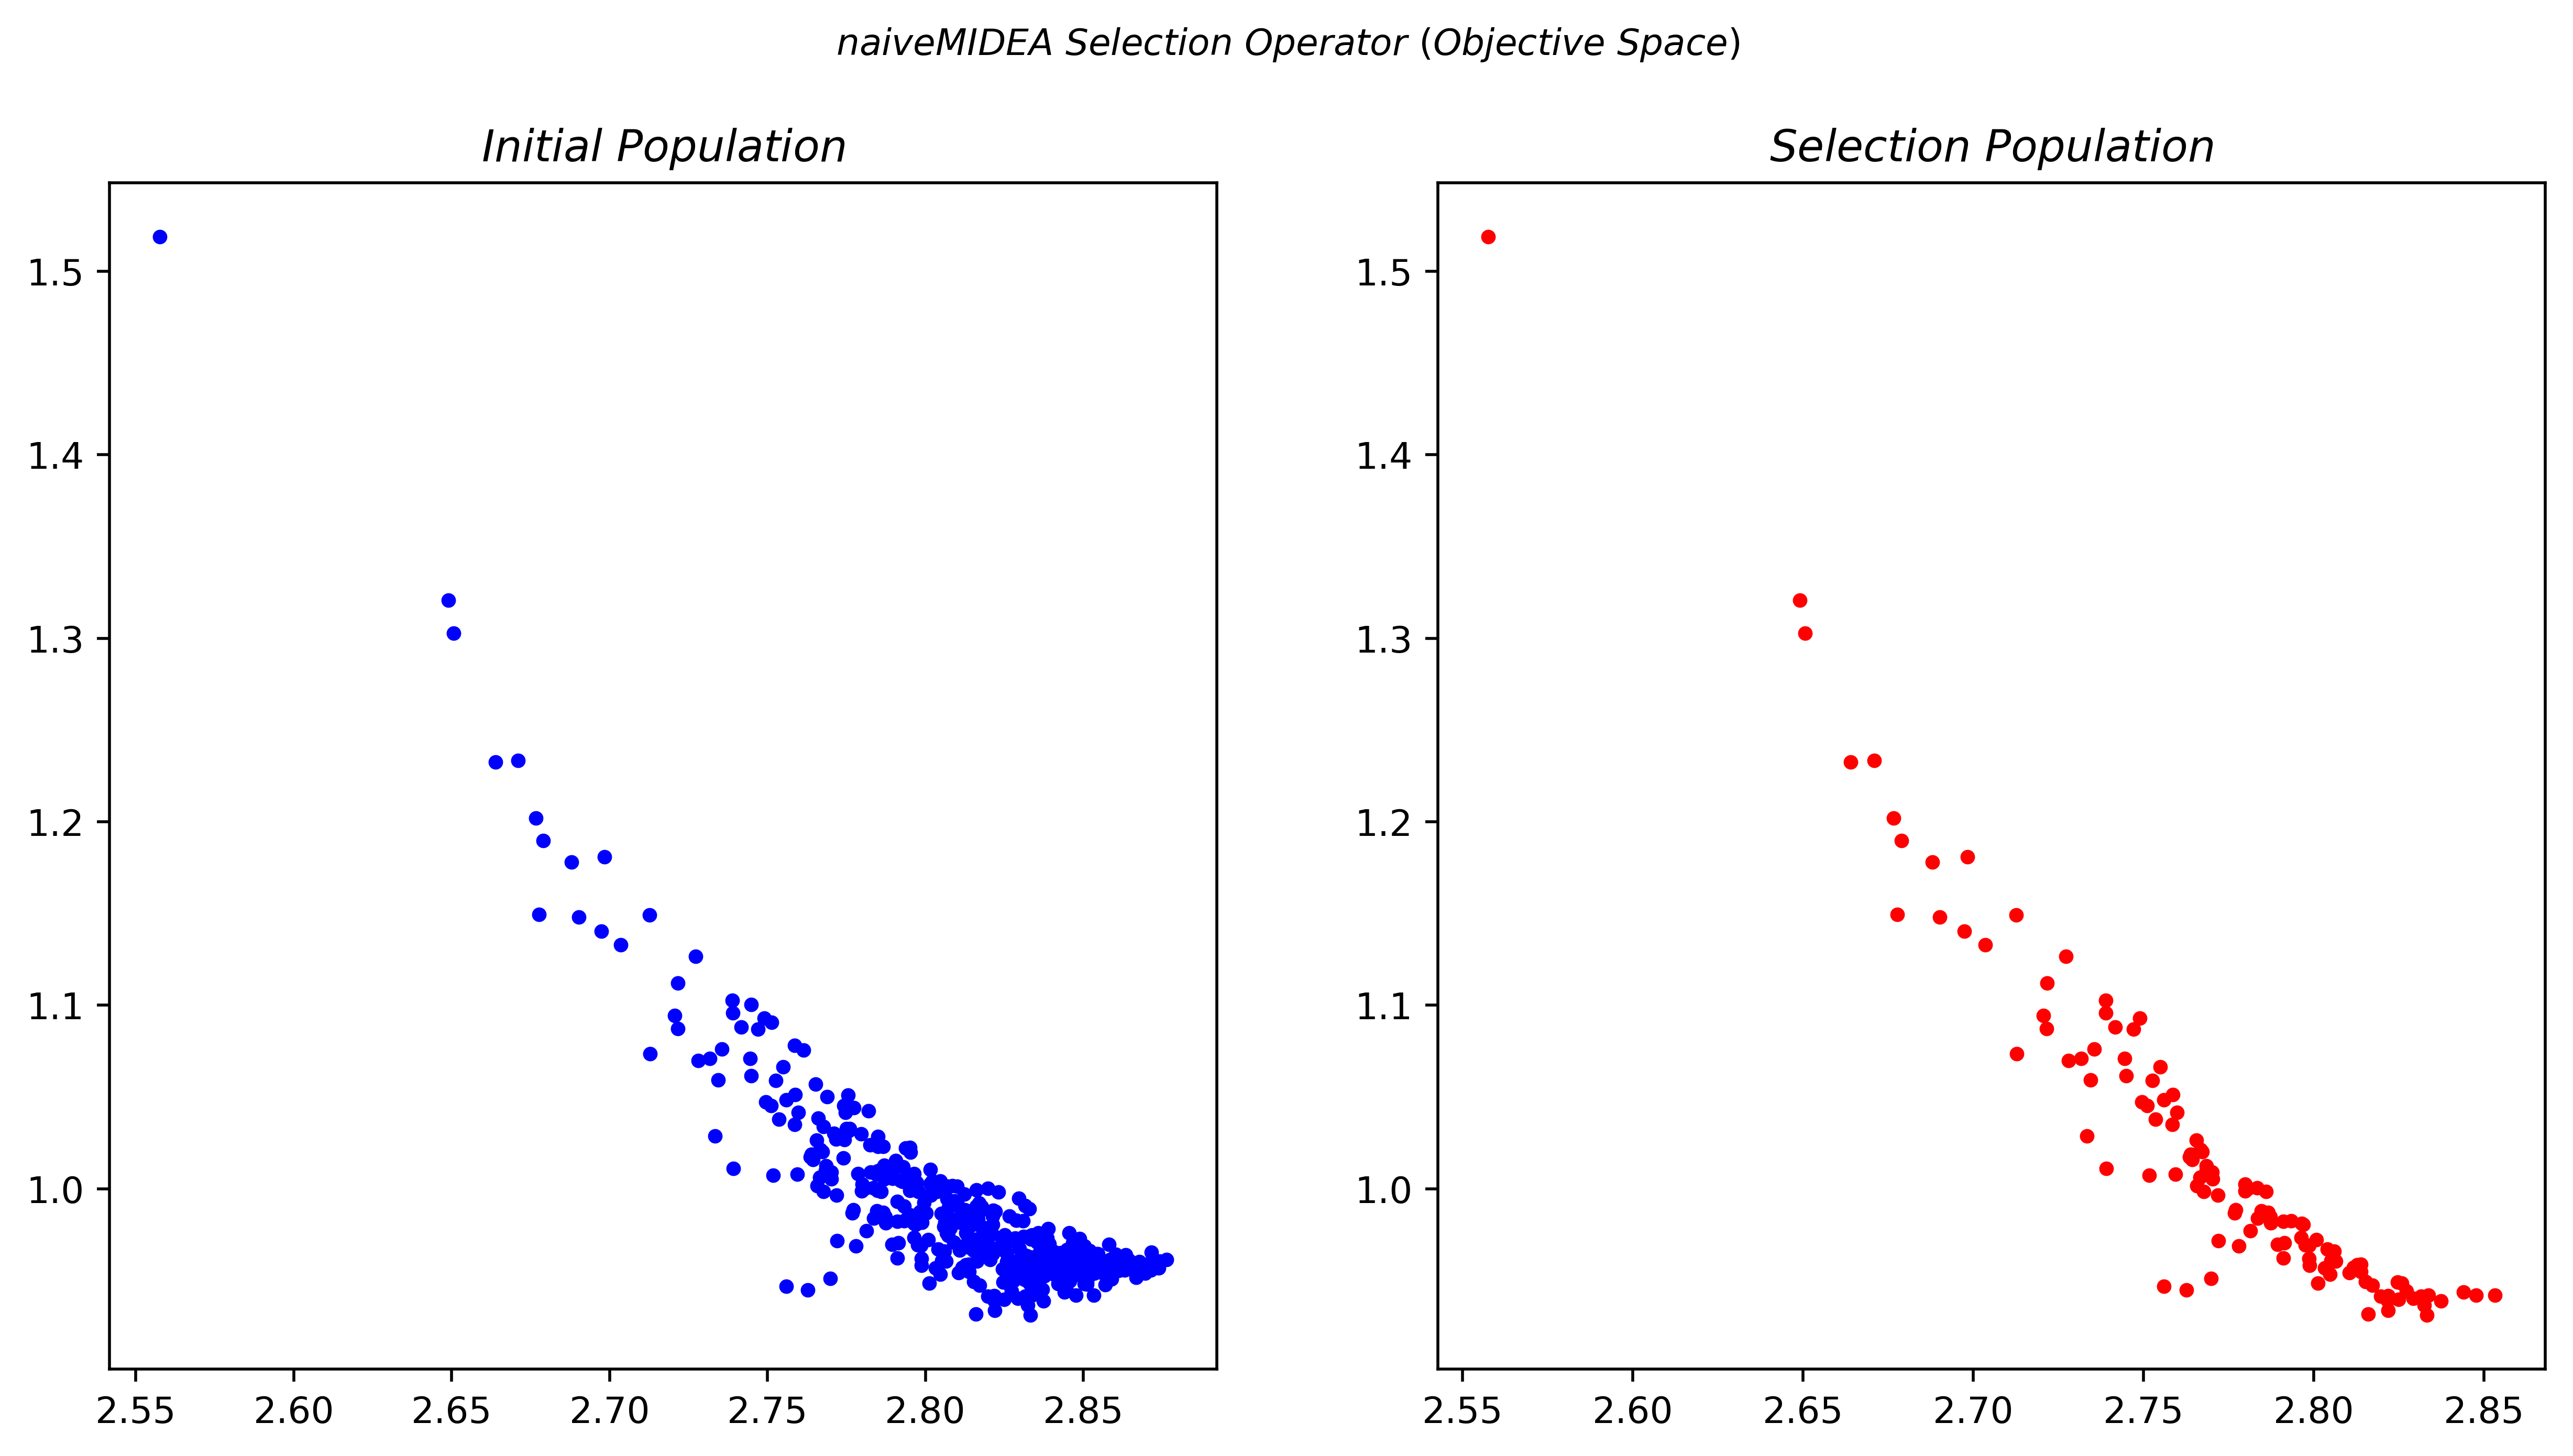

In [9]:
pareto_solutions = np.asarray([ind.fitness.values for ind in pareto_sel])

f = plt.figure(num = 1, figsize = (12, 6), dpi = 500)
f.suptitle('$naive MIDEA$ $Selection$ $Operator$ ($Objective$ $Space$)', fontsize=10)

ax1 = plt.subplot(121)
ax1.set_title('$Initial$ $Population$')
pop_inicial2 = np.asarray(list(fitnesses2))

ax1.plot(pop_inicial2[:,0], pop_inicial2[:,1], '.b') 
ax2 = plt.subplot(122)
ax2.set_title('$Selection$ $Population$')
ax2.plot(pareto_solutions[:,0], pareto_solutions[:,1], '.r') 

### $Clustering$ $Process$ $(Leader$ $Algorithm)$ 

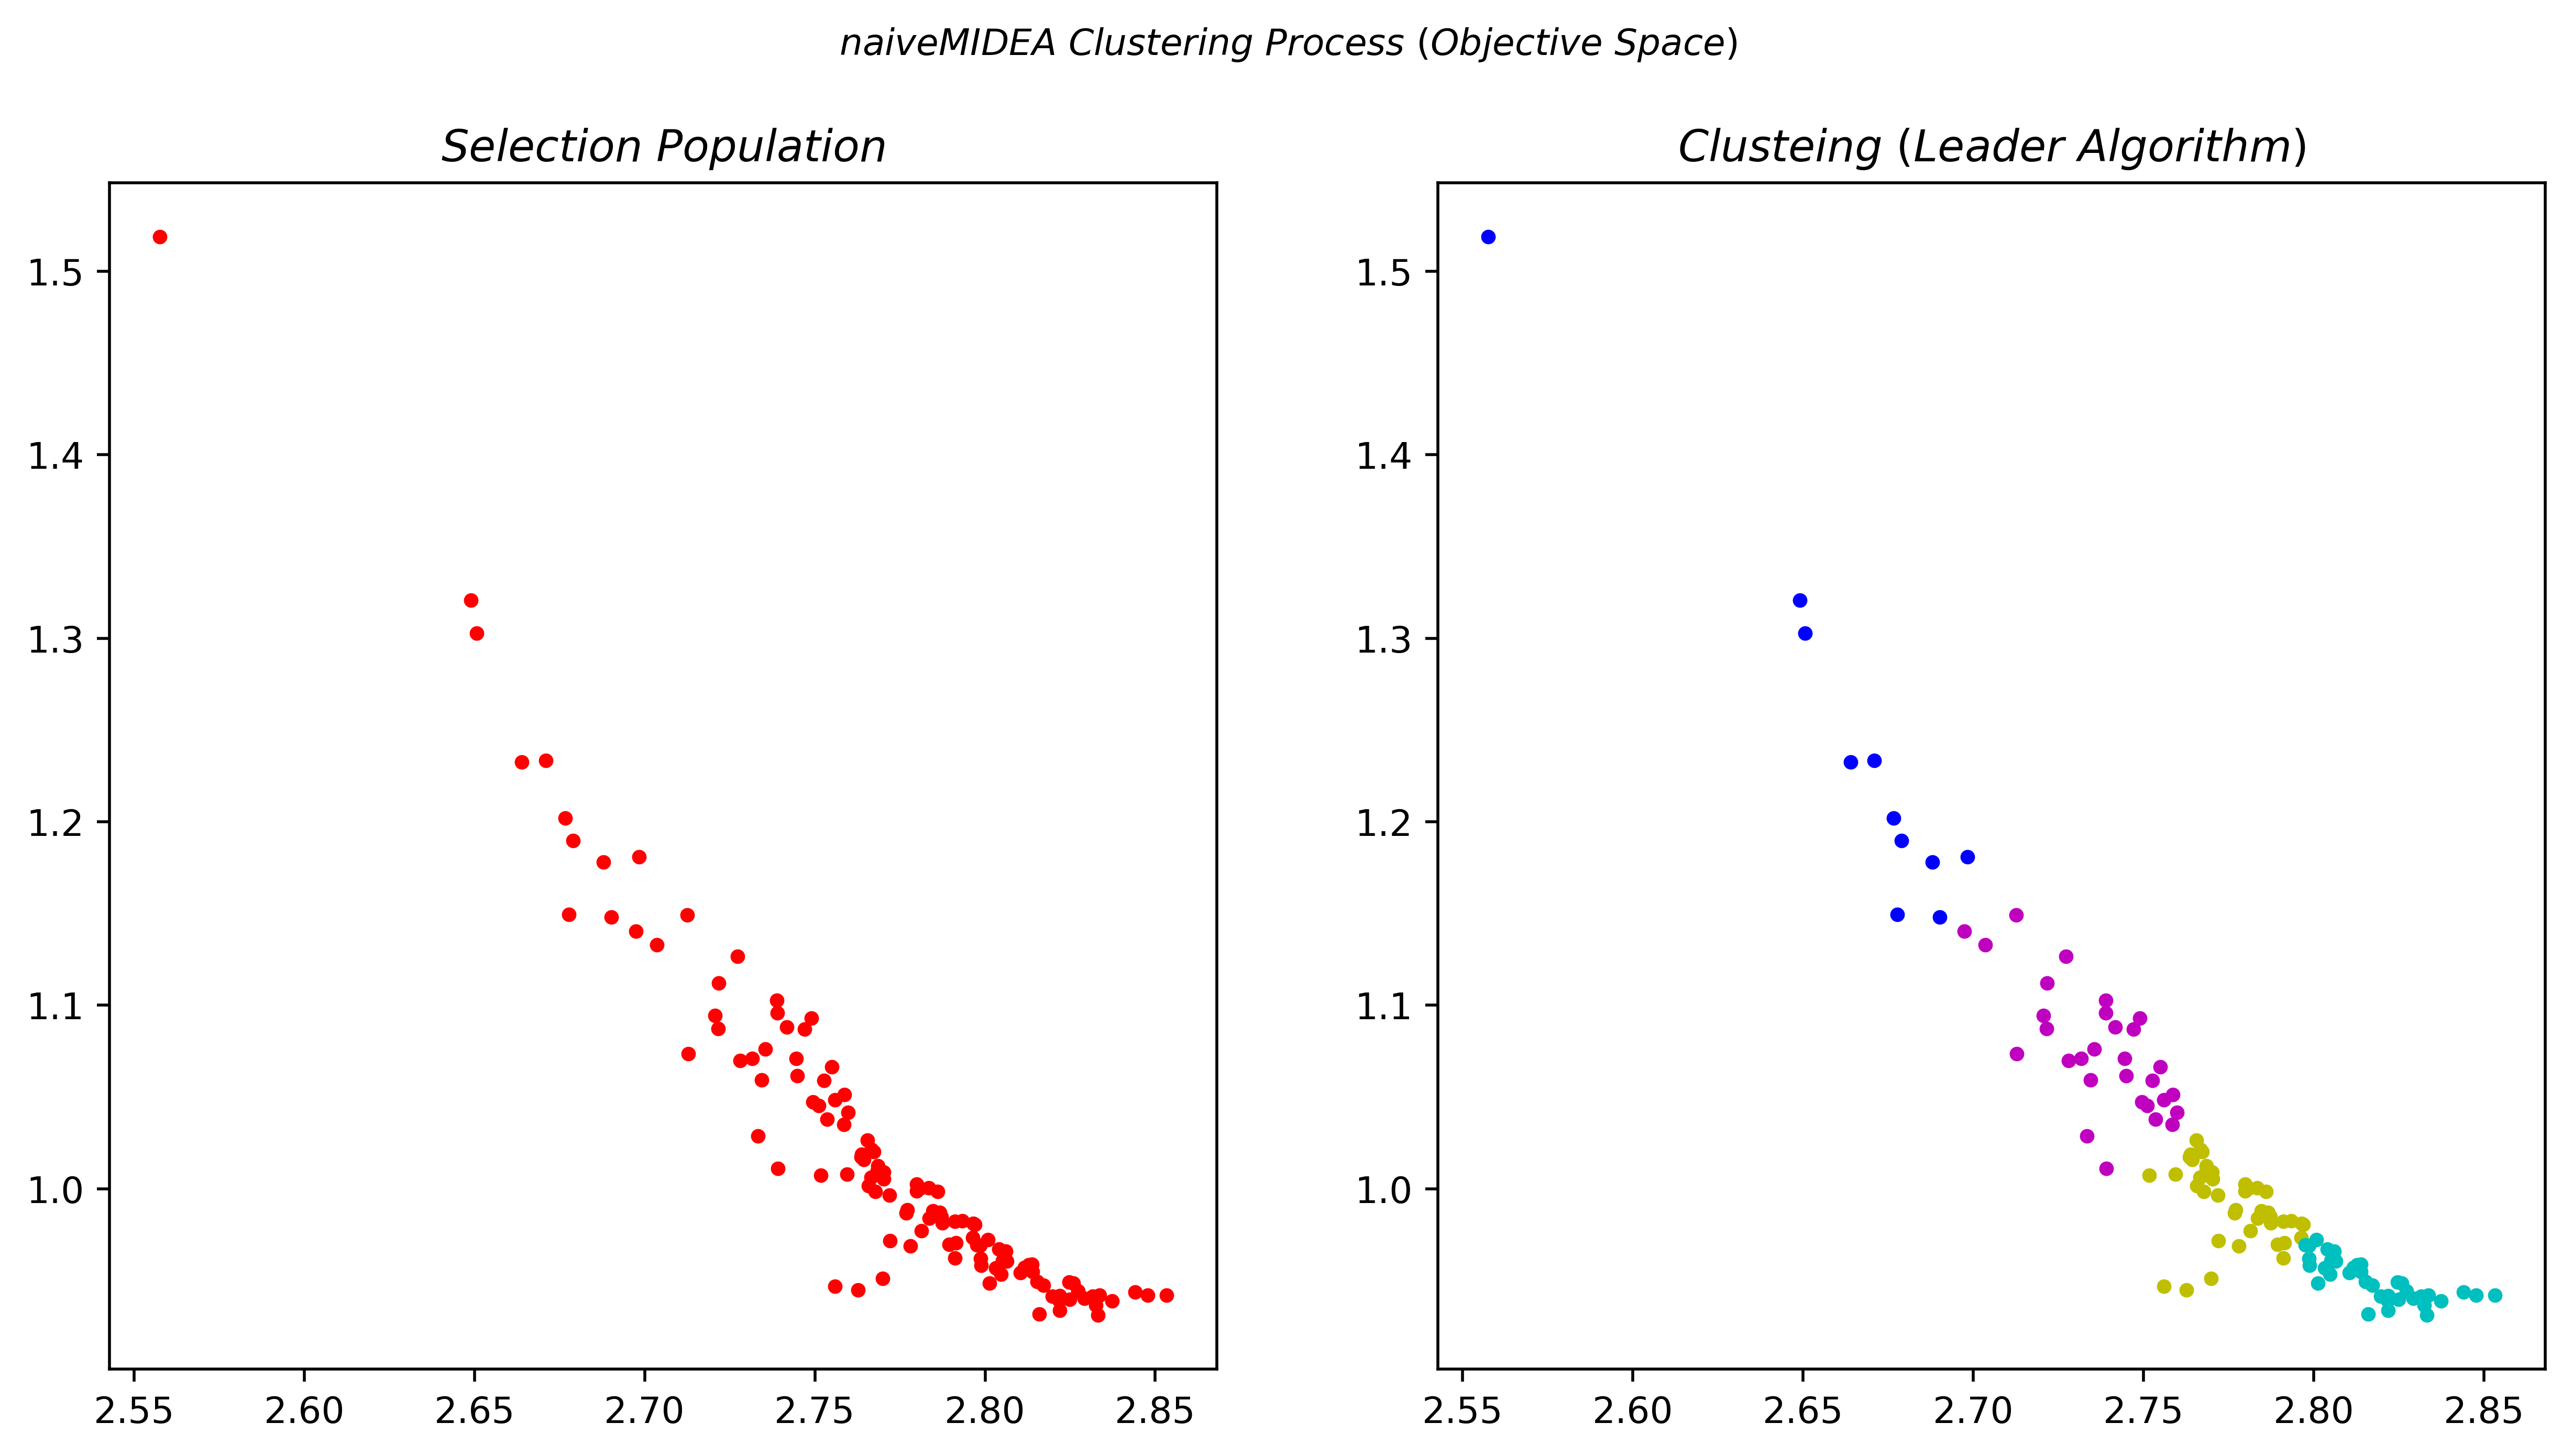

In [10]:
f = plt.figure(num = 2, figsize = (12, 6), dpi = 500)
f.suptitle('$naive MIDEA$ $Clustering$ $Process$ ($Objective$ $Space$)', fontsize=10)

ax1 = plt.subplot(121)
ax1.set_title('$Selection$ $Population$')
ax1.plot(pareto_solutions[:,0], pareto_solutions[:,1], '.r') 

c1 = np.asarray(clusters_OS[0])
c2 = np.asarray(clusters_OS[1])
c3 = np.asarray(clusters_OS[2])
c4 = np.asarray(clusters_OS[3])

ax2 = plt.subplot(122)
ax2.set_title('$Clusteing$ ($Leader$ $Algorithm$)')
ax2.plot(c1[:,0],c1[:,1],'.b',
         c2[:,0],c2[:,1],'.y',
         c3[:,0],c3[:,1],'.m',
         c4[:,0],c4[:,1],'.c') 

### $Estimate$ $Mixture$ $PDF$ $for$ $each$ $variable$ 

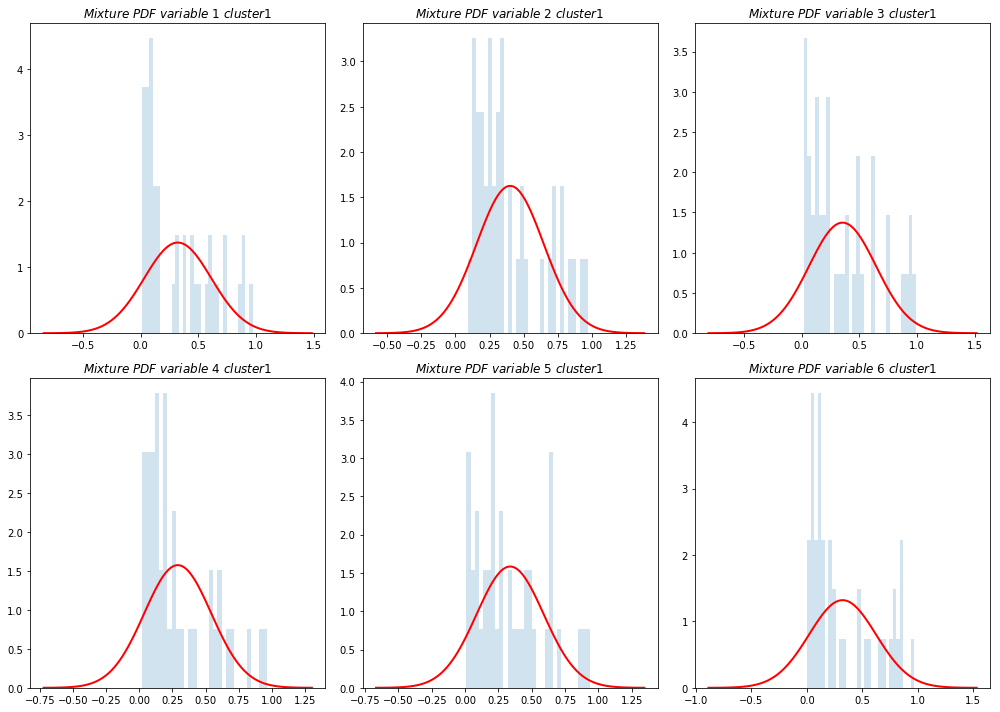

In [11]:
A = clusters_DS[1]
prob_variables = [[fila[j] for fila in A] for j in range(len(A[0]))]

P1 = prob_variables[0]
P2 = prob_variables[1]
P3 = prob_variables[2]
P4 = prob_variables[3]
P5 = prob_variables[4]
P6 = prob_variables[5]


mu1 = PDF_est[1][0][0]
sig1 = PDF_est[1][0][1] 

mu2 = PDF_est[1][1][0]
sig2 = PDF_est[1][1][1] 

mu3 = PDF_est[1][2][0]
sig3 = PDF_est[1][2][1] 

mu4 = PDF_est[1][3][0]
sig4 = PDF_est[1][3][1] 

mu5 = PDF_est[1][4][0]
sig5 = PDF_est[1][4][1] 

mu6 = PDF_est[1][5][0]
sig6 = PDF_est[1][5][1]

plt.figure(1, figsize=(14,10))

plt.subplot(231)
plot_normal_sample(P1, mu1, sig1)
plt.title('$Mixture$ $PDF$ $variable$ $1$ $cluster1$')

plt.subplot(232)
plot_normal_sample(P2, mu2, sig2)
plt.title('$Mixture$ $PDF$ $variable$ $2$ $cluster1$')

plt.subplot(233)
plot_normal_sample(P3, mu3, sig3)
plt.title('$Mixture$ $PDF$ $variable$ $3$ $cluster1$')

plt.subplot(234)
plot_normal_sample(P4, mu4, sig4)
plt.title('$Mixture$ $PDF$ $variable$ $4$ $cluster1$')

plt.subplot(235)
plot_normal_sample(P5, mu5, sig5)
plt.title('$Mixture$ $PDF$ $variable$ $5$ $cluster1$')

plt.subplot(236)
plot_normal_sample(P6, mu6, sig6)
plt.title('$Mixture$ $PDF$ $variable$ $6$ $cluster1$')
plt.tight_layout()


### $Define$ $main$ $loop$ $for$ $naive$ $MIDEA$ $Algorithm$ 

In [12]:
def main_naiveMIDEA(seed, NGEN, MU, tau, k):
    random.seed(seed)

    # Objects that will compile the best front and its hypervolume at each iteration
    objetive_space_values = np.ndarray((NGEN,MU,2))
    hypervolume_front = np.ndarray((NGEN,1)) 
    
    # Objects that will compile the Convergence and Diversity metrics for the best front at each iteration
    conver_metric = np.ndarray((NGEN,1))
    diver_metric = np.ndarray((NGEN,1))
    
    # Random parent population (Initial population)
    pop = toolbox.population(n=MU)
    
    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in pop if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit
            
    # Assign the first object values (best front and Hypervolume)
    front = np.array([ind.fitness.values for ind in pop])
    objetive_space_values[0, :MU, :2] = front
    referencePoint = [11.0, 11.0]
    hv = HyperVolume(referencePoint)
    hypervolume_front[0] = hv.compute(front)
    
    # Assign the first Convergence and Diversity values 
    pop_copy = copy.copy(pop)
    pop_copy.sort(key=lambda x: x.fitness.values)
    conver_metric[0] = convergence(pop_copy, optimal_front)
    diver_metric[0] = diversity(pop_copy, optimal_front[0], optimal_front[-1])
    
    # Begin the generational process
    for gen in range(1, NGEN):
        # Make set of new offspring
        offspring, pareto_sel, clusters_OS, clusters_DS, PDF_est = estMPDnMIDEA(pop, tau, k)        
        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring]# if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit
            
        # Select the next generation population
        pop = copy.deepcopy(offspring)
        
        # Save data along the evolution progress (objetive space and Hypervolume for the best front values)  
        front = np.array([ind.fitness.values for ind in pop])
        objetive_space_values[gen, :MU, :2] = front
        referencePoint = [11.0, 11.0]
        hv = HyperVolume(referencePoint)
        hypervolume_front[gen] = hv.compute(front)
        
        # Save data along the evolution progress (Convergence and Diversity values for the current best front)
        pop_copy = copy.copy(pop)
        pop_copy.sort(key=lambda x: x.fitness.values)
        conver_metric[gen] = convergence(pop_copy, optimal_front)
        diver_metric[gen] = diversity(pop_copy, optimal_front[0], optimal_front[-1])
            
    return objetive_space_values, hypervolume_front, conver_metric, diver_metric

### $Import$ $Pareto$ $Front$ $data$ $for$ $WFG1$ $benchmark$ $problem$

In [13]:
# Open a previously stored true Pareto Front data set
with open("WFG1_PF.json") as optimal_front_data:
    optimal_front = json.load(optimal_front_data)
    # Use only half of data points
    optimal_front = sorted(optimal_front[i] for i in range(0, len(optimal_front), 2))

### $Configuration$ $and$ $Execution$

In [14]:
#Random initialization seed
seed = None

#Number of Generations
NGEN = 100

#Number of Individuals in Population
MU = 150

#Threshold param  
tau = 0.4

#Number of clusters at objective space solutions
k = 4

# Execution Algorithm
objetive_space_values, hypervolume_front, conver_metric, diver_metric = main_naiveMIDEA(seed, NGEN, MU, tau, k)

### $Visualization$ $of$ $Optimization$ $Results$ 

MovieWriter imagemagick unavailable.


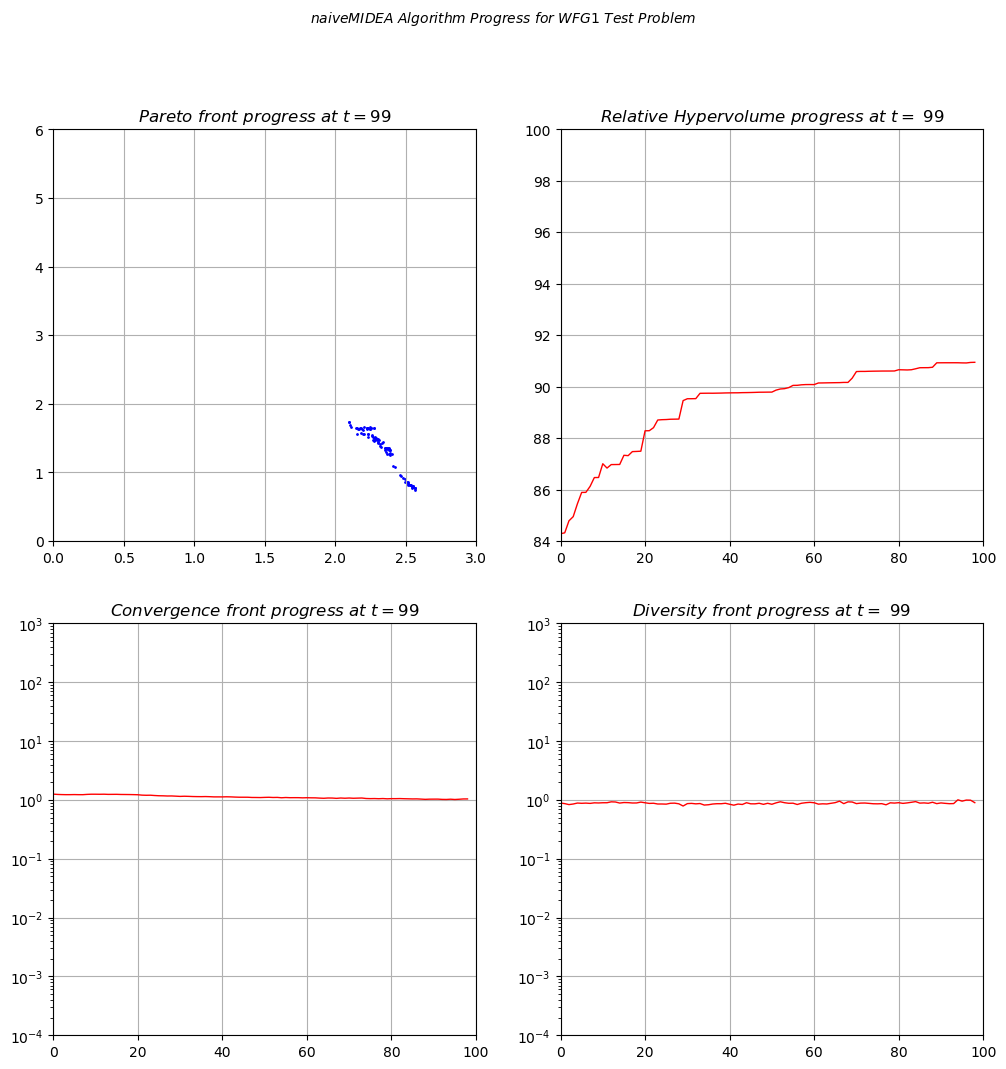

In [15]:
fig = plt.figure(figsize = (12, 12), dpi = 100)
fig.suptitle('$naiveMIDEA$ $Algorithm$ $Progress$ $for$ $WFG1$ $Test$ $Problem$', fontsize=10)

ax1 = matplotlib.pyplot.subplot2grid((2, 2), (0, 0))
ax2 = matplotlib.pyplot.subplot2grid((2, 2), (0, 1))
ax3 = matplotlib.pyplot.subplot2grid((2, 2), (1, 0))
ax4 = matplotlib.pyplot.subplot2grid((2, 2), (1, 1))

ax1.set_ylim(0,round(max(objetive_space_values[0,:,1]))+5)
ax2.set_ylim((int(min(hypervolume_front)),int(max(hypervolume_front))+10))
ax3.set_ylim(0.0001,1000)
ax4.set_ylim(0.0001,1000)
#ax3.set_ylim((int(min(conver_metric)),int(max(conver_metric))+1))
#ax4.set_ylim((int(min(diver_metric)),int(max(diver_metric))+1))

ax1.set_xlim(0,round(max(objetive_space_values[0,:,0])))
ax2.set_xlim(0,NGEN)
ax3.set_xlim(0,NGEN)
ax4.set_xlim(0,NGEN)

ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()

scat = ax1.scatter([], [], s=1, c='blue')
line1, = ax2.plot([], [], lw=1, color='red')
line2, = ax3.semilogy([], [], lw=1, color='red')
line3, = ax4.semilogy([], [], lw=1, color='red')

def init():
    scat.set_offsets([])
    line1.set_data([], [])
    line2.set_data([], [])
    line3.set_data([], [])
    return scat, line1, line2, line3

def animate(i):
    ax1.set_title('$Pareto$ $front$ $progress$ $at$ $t=$' +str(i))
    ax2.set_title('$Relative$ $Hypervolume$ $progress$ $at$ $t=$ '+str(i))
    ax3.set_title('$Convergence$ $front$ $progress$ $at$ $t=$' +str(i))
    ax4.set_title('$Diversity$ $front$ $progress$ $at$ $t=$ '+str(i))
    scat.set_offsets(objetive_space_values[i])
    x = list(range(0,i,1))
    line1.set_data(x, hypervolume_front[:i])
    line2.set_data(x, conver_metric[:i]) 
    line3.set_data(x, diver_metric[:i])
    return scat, line1, line2, line3

anim = FuncAnimation(fig, animate, init_func=init, frames=NGEN, interval=200, blit=True)
anim.save('naiveMIDEA Algorithm Progress(WFG1).gif', writer='imagemagick')

In [2]:
Image(url='naiveMIDEA Algorithm Progress(WFG1).gif')

NameError: name 'Image' is not defined

## $Optimization$ $results$ $for$ $others$ $test$ $problems$

### $ZDT1$ $naiveMIDEA$ $test$ $problem$ 

In [15]:
Image(url='naiveMIDEA Algorithm Progress(ZDT1).gif')

### $ZDT2$ $naiveMIDEA$ $test$ $problem$ 

In [16]:
Image(url='naiveMIDEA Algorithm Progress(ZDT2).gif')

### $ZDT3$ $naiveMIDEA$ $test$ $problem$ 

In [17]:
Image(url='naiveMIDEA Algorithm Progress(ZDT3).gif')